### **Load libraries**

In [1]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
from mgarch import mgarch
import importlib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [4]:
rets = pd.read_csv('selected_stocks_rets.csv', index_col=0)
stocks = pd.read_csv('selected_stocks_stocks.csv', index_col=0)

In [5]:
expected_returns = pd.read_csv('expected_returns.csv', index_col=0, header=None).iloc[:,0]
expected_covmat = pd.read_csv('expected_covmat.csv', index_col=0)

In [6]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

# **Initial examination**

In [7]:
summary_stats = rk.summary_stats(rets, periods_per_year=periods_per_year, riskfree_rate=0)
summary_stats

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
BCOLOMBIA.CL,0.137056,0.362499,0.374000,14.825009,0.060394,0.096261,0.378085,-0.581655
BOGOTA.CL,0.000151,0.277339,-0.792562,13.176732,0.061649,0.096779,0.000544,-0.633000
BVC.CL,0.104468,0.253333,0.687792,7.163759,0.044335,0.069545,0.412373,-0.356135
CELSIA.CL,0.094113,0.288932,2.123218,21.873496,0.020233,0.078573,0.325727,-0.513461
CEMARGOS.CL,0.051813,0.387379,2.724399,42.942758,-0.006211,0.101128,0.133752,-0.782714
CONCONCRET.CL,-0.082492,1.087581,15.780037,323.879858,-2.075459,0.140517,-0.075849,-0.864859
CORFICOLCF.CL,-0.011957,0.290939,0.065143,8.052363,0.059786,0.092212,-0.041097,-0.600359
ECOPETROL.CL,0.080204,0.385999,-0.311694,9.210322,0.081536,0.114029,0.207783,-0.615934
ENKA.CL,0.055652,0.396137,1.947305,14.338255,0.040279,0.099571,0.140488,-0.562287
ETB.CL,-0.203629,0.350725,0.644660,9.394029,0.066306,0.116314,-0.580593,-0.928790


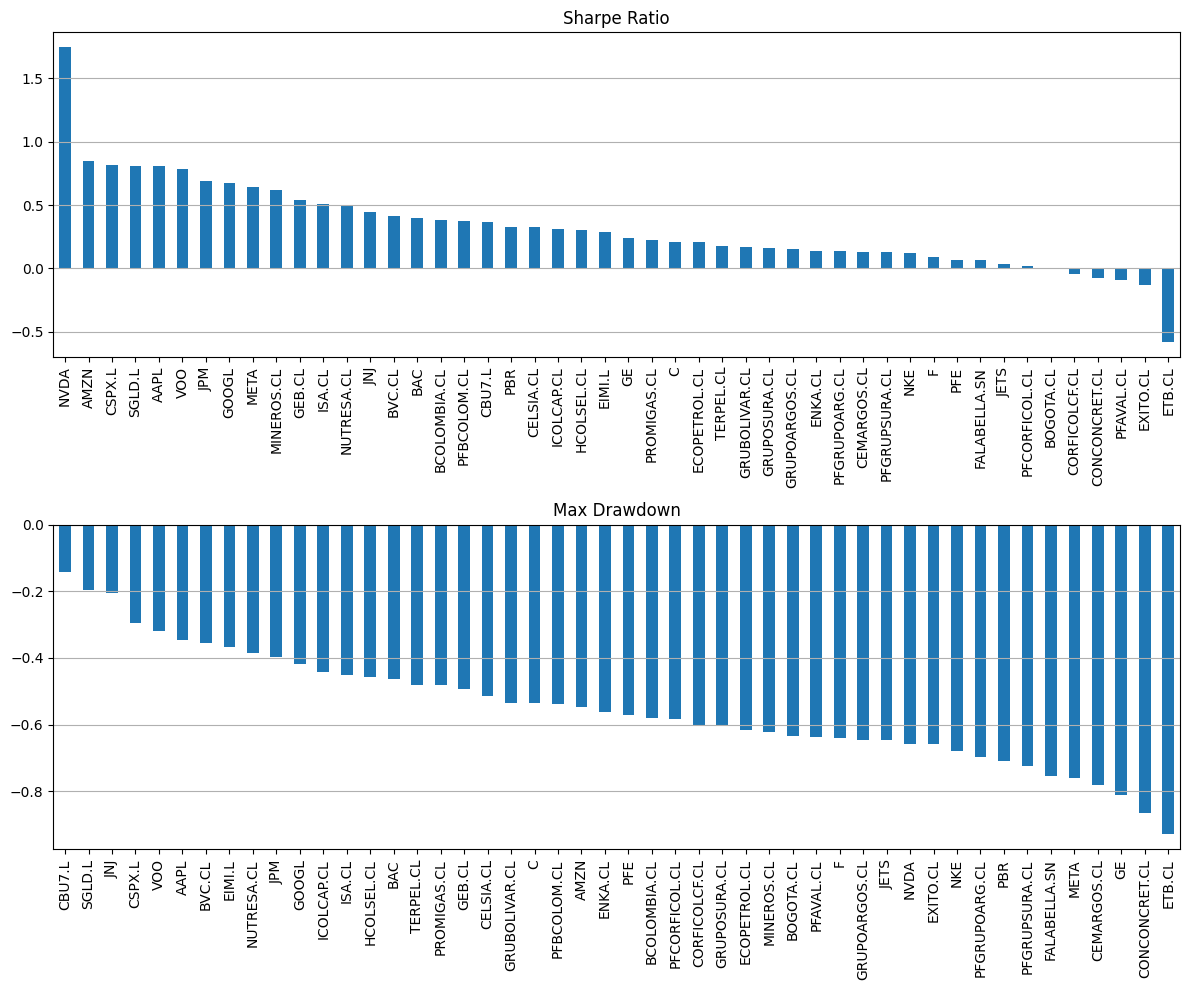

In [8]:
# Plot some return, volatility, and risk rankings to get a view of relevant stocks
summary_stats = rk.summary_stats(rets, periods_per_year=periods_per_year)
#plot1_series = summary_stats['Annualized Return'].sort_values(ascending=False)
#plot2_series = summary_stats['Annualized Volatility'].sort_values(ascending=True)
#plot1_series = summary_stats['Cornish-Fisher VaR (5%)'].sort_values(ascending=False)
#plot2_series = summary_stats['Historic CVaR (5%)'].sort_values(ascending=False)
plot1_series = summary_stats['Sharpe Ratio'].sort_values(ascending=False)
plot2_series = summary_stats['Max Drawdown'].sort_values(ascending=False)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
plot1_series.plot.bar(ax = axes[0], legend=False, title=plot1_series.name)
plot2_series.plot.bar(ax=axes[1], legend=False, title=plot2_series.name)
axes[0].grid(axis='y')
axes[1].grid(axis='y')
plt.tight_layout()

In [9]:
# Identify stock pairs with very high correlation

# Generate correlation matrix
corr_mat = rets.corr()
# Generate a mask to exclude  duplicated pairs
#mask = np.triu(np.ones_like(corr_mat))
#corr_mat = corr_mat*mask
# Convert the matrix into a dataframe structured as a list of pairs with their respective correlations
stack_corr = pd.DataFrame(corr_mat.stack())
stack_corr = stack_corr[stack_corr[0] < 1]
stack_corr = stack_corr[stack_corr[0] != 0]
stack_corr.index.names = ['Stock 1', 'Stock 2']
stack_corr.reset_index(inplace=True)
#(abs(stack_corr[0]) > .7).sum()

# Filter to visualize only the pairs with very high correlations
high_corrs = stack_corr[stack_corr[0] >= 0.8].sort_values(by=0, ascending=False)
high_corrs

,Stock 1,Stock 2,0
1550,CSPX.L,VOO,0.922317
2241,VOO,CSPX.L,0.922317
1402,BAC,JPM,0.893815
1909,JPM,BAC,0.893815
20,BCOLOMBIA.CL,PFBCOLOM.CL,0.892549
987,PFBCOLOM.CL,BCOLOMBIA.CL,0.892549
1392,BAC,C,0.870400
1439,C,BAC,0.870400
1449,C,JPM,0.866170
1910,JPM,C,0.866170


In [10]:
# Check the average correlation coefficient of each stock
stack_corr.groupby('Stock 1')[0].mean().sort_values(ascending=False)

Stock 1
ICOLCAP.CL       0.382683
VOO              0.361296
CSPX.L           0.349489
HCOLSEL.CL       0.339231
C                0.314235
PFGRUPSURA.CL    0.312084
PFBCOLOM.CL      0.311819
EIMI.L           0.308285
BCOLOMBIA.CL     0.305480
JETS             0.301635
PFAVAL.CL        0.299836
JPM              0.280674
CEMARGOS.CL      0.279570
PFGRUPOARG.CL    0.278444
GRUPOARGOS.CL    0.276807
BAC              0.270024
ECOPETROL.CL     0.266129
CORFICOLCF.CL    0.257714
F                0.252880
GE               0.243607
NKE              0.240761
GRUPOSURA.CL     0.239726
ISA.CL           0.233921
GOOGL            0.225143
AAPL             0.213169
PBR              0.212042
CELSIA.CL        0.208041
BOGOTA.CL        0.206005
NVDA             0.192462
META             0.187393
JNJ              0.184271
GRUBOLIVAR.CL    0.183759
MINEROS.CL       0.182267
AMZN             0.179586
PFCORFICOL.CL    0.174271
GEB.CL           0.166229
FALABELLA.SN     0.156120
PFE              0.153422
ETB.

# **Identify Combination with the maximum Sharpe-Ratio**

In [11]:
# Based on historical returns
n_periods = 162
# returns = rk.summary_stats(rets.iloc[-n_periods:], periods_per_year=periods_per_year)['Annualized Return']
# covmat = rets.iloc[-n_periods:].cov()

# Based on predicted returns
returns = expected_returns
covmat = expected_covmat

In [12]:
# Loop that calculates the combination that maximizes the Sharpe ratio several times until no stock has less than 5% of weight
rf_rate = .11   # Currently, the 10-Y  bond yield is at 11.2%
max_weight = 0.4 # The maximum weight allowed for a stock
initial_weights = rk.msr_tuned(riskfree_rate=rf_rate,
                         returns=returns,
                         covmat=covmat,
                         max_weight=max_weight,
                         periods_per_year=periods_per_year)
optimal_allocation = pd.DataFrame(data=initial_weights, index=returns.index, columns=['Weights']).sort_values(by='Weights')

while optimal_allocation.min().values < .05:
    optimal_allocation = optimal_allocation[1:]
    weights = rk.msr_tuned(riskfree_rate=rf_rate,
                     returns=returns[optimal_allocation.index],
                     covmat=covmat.loc[optimal_allocation.index, optimal_allocation.index],
                     max_weight=max_weight,
                     periods_per_year=periods_per_year)
    optimal_allocation = pd.DataFrame(data=weights, index=optimal_allocation.index, columns=['Weights']).sort_values(by='Weights')

chosen_allocation = optimal_allocation
chosen_allocation

,Weights
0,
GE,0.055652
PFE,0.066136
FALABELLA.SN,0.072583
TERPEL.CL,0.077370
NUTRESA.CL,0.082793
ETB.CL,0.090564
AAPL,0.131539
CSPX.L,0.182722
PFGRUPOARG.CL,0.240641


In [13]:
"""
# Alternative methodology finding the combination that maximizes the Sharpe ratio and then removing any stock with a weight below 5%
rf_rate = .11   # Currently, the 10-Y  bond yield is at 11.2%

weights = rk.msr(riskfree_rate=rf_rate, return_series=rets, periods_per_year=periods_per_year)
optimal_allocation = pd.DataFrame(data=weights.round(4), index=rets.columns, columns=['Weights'])
optimal_allocation = optimal_allocation[optimal_allocation['Weights'] >= .05]

# Reduce the portfolio stocks to only those for which shares of over 3% is recommended
chosen_allocation = optimal_allocation[optimal_allocation['Weights'] > .05]
chosen_allocation = chosen_allocation / chosen_allocation.sum()
chosen_allocation.sort_values(by='Weights')
"""

"\n# Alternative methodology finding the combination that maximizes the Sharpe ratio and then removing any stock with a weight below 5%\nrf_rate = .11   # Currently, the 10-Y  bond yield is at 11.2%\n\nweights = rk.msr(riskfree_rate=rf_rate, return_series=rets, periods_per_year=periods_per_year)\noptimal_allocation = pd.DataFrame(data=weights.round(4), index=rets.columns, columns=['Weights'])\noptimal_allocation = optimal_allocation[optimal_allocation['Weights'] >= .05]\n\n# Reduce the portfolio stocks to only those for which shares of over 3% is recommended\nchosen_allocation = optimal_allocation[optimal_allocation['Weights'] > .05]\nchosen_allocation = chosen_allocation / chosen_allocation.sum()\nchosen_allocation.sort_values(by='Weights')\n"

<Axes: xlabel='Date'>

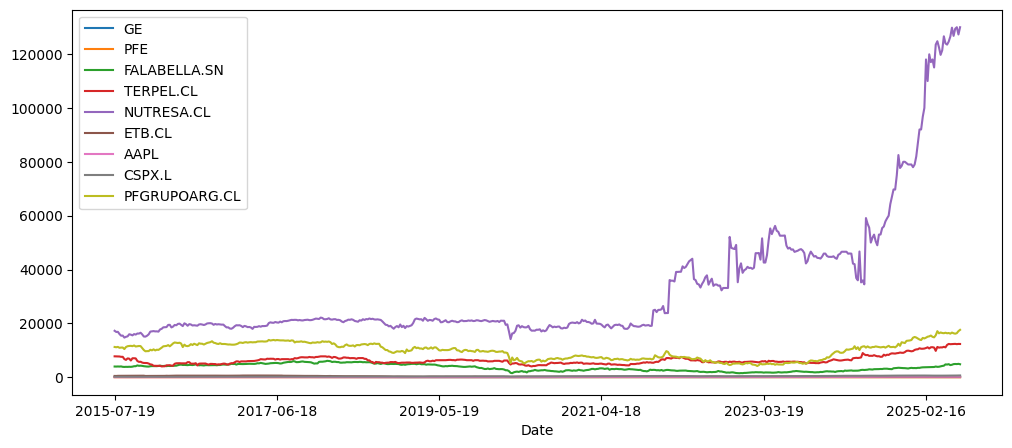

In [14]:
stocks[optimal_allocation.index].plot(figsize=(12, 5))

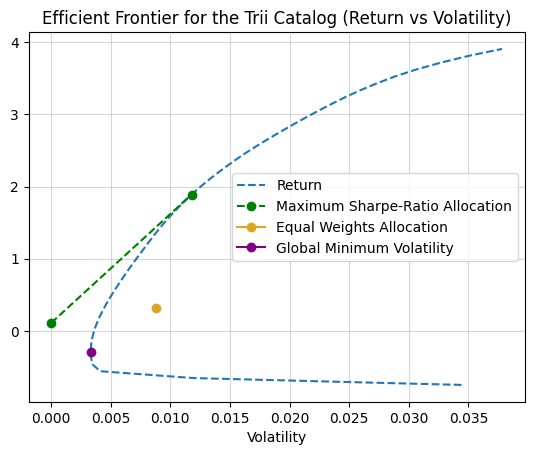

In [15]:
rk.plot_ef(50, style = '--', show_cml=True, show_ew=True, show_gmv=True, riskfree_rate=rf_rate,
           returns=returns, covmat=covmat, periods_per_year=periods_per_year)
plt.title('Efficient Frontier for the Trii Catalog (Return vs Volatility)')
plt.grid(alpha=.5)

# **Create an index for the chosen allocation**

In [16]:
# Generate a dataframe to represent the evolution of the allocation in each stock
weights = chosen_allocation['Weights']
allocated_index = (rets[weights.index] + 1).cumprod()*weights

# Add a column to represent the index
allocated_index['index'] = allocated_index.sum(axis='columns')
allocated_index.index = pd.to_datetime(allocated_index.index.str.split('/').str[0])

# Generate a row to represent an earlier period before returns are made,
# corresponding to the time when the index equal 1
first_period = allocated_index.index[0]
starting_period = first_period - pd.offsets.Week(weekday=6)   # Uncomment to generate a week starting period
#starting_period = first_period - pd.offsets.DateOffset(months=1)   # Uncomment to generate a month starting period
starting_period

allocation_start = pd.DataFrame(index=[starting_period], columns=allocated_index.columns)
allocation_start.iloc[:, :-1] = 1*weights
allocation_start['index'] = 1

# Append the row to the allocated_index dataframe
allocated_index = pd.concat([allocation_start, allocated_index], axis='rows')
allocated_index.head()

,GE,PFE,FALABELLA.SN,TERPEL.CL,NUTRESA.CL,ETB.CL,AAPL,CSPX.L,PFGRUPOARG.CL,index
2015-07-19,0.055652,0.066136,0.072583,0.07737,0.082793,0.090564,0.131539,0.182722,0.240641,1.000000
2015-07-26,0.052607,0.064608,0.072291,0.07727,0.080705,0.088972,0.126343,0.180238,0.238617,0.981652
2015-08-02,0.053323,0.068003,0.072862,0.07727,0.080921,0.097285,0.123096,0.181891,0.24122,0.995871
2015-08-09,0.052689,0.066362,0.072339,0.076768,0.077034,0.09587,0.11723,0.178268,0.234278,0.970839
2015-08-16,0.053282,0.067127,0.07319,0.075564,0.07401,0.099054,0.118209,0.179552,0.236014,0.976002


In [17]:
# Generate a dataframe with the returns of the index
allocated_index_returns = (allocated_index/allocated_index.shift(1) - 1).dropna()
allocated_index_returns.head()

,GE,PFE,FALABELLA.SN,TERPEL.CL,NUTRESA.CL,ETB.CL,AAPL,CSPX.L,PFGRUPOARG.CL,index
2015-07-26,-0.054699,-0.023097,-0.004026,-0.001297,-0.025218,-0.017578,-0.0395,-0.013593,-0.008414,-0.018348
2015-08-02,0.013592,0.05254,0.007901,0.0,0.002678,0.093439,-0.025703,0.00917,0.010909,0.014485
2015-08-09,-0.011877,-0.024127,-0.007178,-0.006493,-0.048044,-0.014545,-0.04765,-0.019918,-0.028777,-0.025135
2015-08-16,0.011245,0.011538,0.011752,-0.015686,-0.039253,0.03321,0.008352,0.007202,0.007407,0.005318
2015-08-23,-0.057132,-0.050396,-0.036774,0.0,0.003897,0.023214,-0.087961,-0.039809,0.001226,-0.024372


In [18]:
summary_stats = rk.summary_stats(allocated_index_returns, periods_per_year=periods_per_year, riskfree_rate=0)
summary_stats

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
GE,0.087287,0.363592,-0.075617,5.030712,0.077634,0.113837,0.240068,-0.811628
PFE,0.015906,0.236340,0.047995,4.360347,0.050769,0.069443,0.067302,-0.571144
FALABELLA.SN,0.020133,0.315357,0.273031,10.169160,0.059699,0.091600,0.063842,-0.754397
TERPEL.CL,0.049224,0.282039,0.536564,8.060146,0.051530,0.087094,0.174530,-0.480604
NUTRESA.CL,0.232784,0.462388,5.176135,55.545487,-0.093045,0.099861,0.503438,-0.386113
ETB.CL,-0.203629,0.350725,0.644660,9.394029,0.066306,0.116314,-0.580593,-0.928790
AAPL,0.228339,0.284105,-0.228623,4.795355,0.060100,0.084055,0.803713,-0.346407
CSPX.L,0.135604,0.166263,-0.703550,9.671974,0.035868,0.052143,0.815596,-0.295079
PFGRUPOARG.CL,0.047552,0.339558,0.731539,16.512200,0.051413,0.098837,0.140040,-0.698413
index,0.120724,0.167404,-0.689451,11.267156,0.035556,0.051828,0.721155,-0.325612


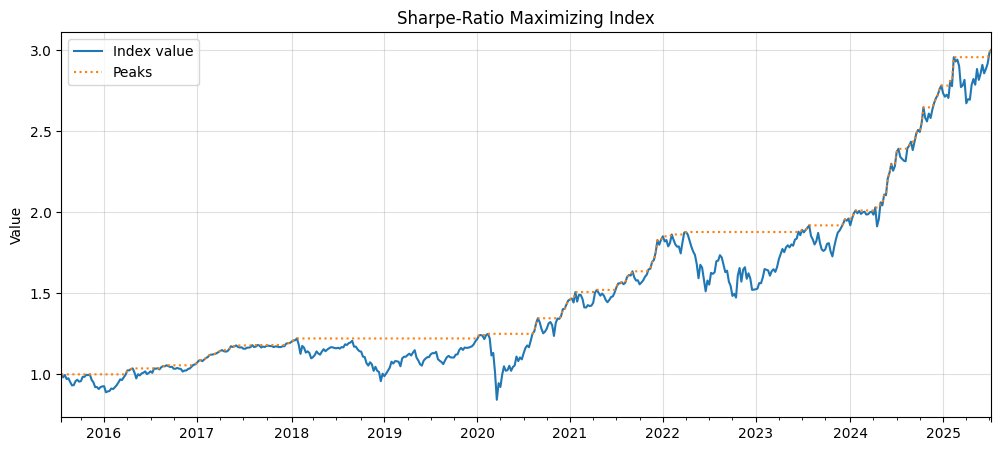

In [19]:
# Visualize the evolution of the index
allocated_index['index'].plot(figsize=(12, 5), label='Index value')
allocated_index['index'].cummax().plot(linestyle=':', label='Peaks')
plt.legend()
plt.ylabel('Value')
plt.title('Sharpe-Ratio Maximizing Index')
plt.grid(alpha=0.4)

### **Export datasets and an index for the Sharpe-Ratio maximizing allocation**

In [20]:
# Allocation index and returns
allocated_index.to_csv('allocated_index.csv')
allocated_index_returns.to_csv('allocated_index_returns.csv')